#### <b>Download the Dataset</b>

In [154]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb1hztk047VFk2j9bI7JKmEBtkWpABZ8vfX5_m0cdSjQHw?download=1 -O custom_korean_family_dataset_resolution_256.zip
!unzip custom_korean_family_dataset_resolution_256.zip -d ./custom_korean_family_dataset_resolution_256

#### <b>Load Libraries</b>

In [ ]:
!pip install facenet_pytorch

In [ ]:
import pandas as pd
import random
import os
from PIL import Image
from torch.utils.data import Dataset

import torch
import torch.nn as nn

from facenet_pytorch import InceptionResnetV1
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
"""
> [Function] Parse the metadata.
* family_list = ["F0001", "F0002", ...]
* family_to_person_map["F0001"] = ["D", "GM", "M"]
* person_to_image_map["F0001_D"] = [
    "F0001_AGE_D_18_a1.jpg",
    "F0001_AGE_D_18_a2.jpg",
    ...
]
"""
def parsing(metadata):
    family_set = set()
    family_to_person_map = dict()
    person_to_image_map = dict()
    # iterate all rows in the metadata file
    for idx, row in metadata.iterrows():
        family_id = row["family_id"]
        person_id = row["person_id"]
        key = family_id + "_" + person_id
        image_path = row["image_path"]
        if family_id not in family_set:
            family_set.add(family_id)
            family_to_person_map[family_id] = []
        if person_id not in family_to_person_map[family_id]:
            family_to_person_map[family_id].append(str(person_id))    
            person_to_image_map[key] = []
        person_to_image_map[key].append(image_path) # save all image paths
    family_list = list(family_set)
    return family_list, family_to_person_map, person_to_image_map

#### <b>Load Datasets</b>

* Training dataset
  * (F0001 ~ F0299) folders have 10,025 images.
* Validation dataset
  * (F0801 ~ F0850) folders have 1,539 images.
* Test dataset
  * (F0851 ~ F0900) folders have 1,504 images.

In [3]:
class TrainDataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # process the meta data
        family_list, family_to_person_map, person_to_image_map = parsing(meta_data)
        self.family_list = family_list
        self.family_to_person_map = family_to_person_map
        self.person_to_image_map = person_to_image_map

    def __len__(self):
        return len(self.meta_data) * 2
               
    def __getitem__(self, idx):
        # positive samples (family)
        if idx % 2 == 0:
            # choice a single family
            family_id = random.choice(self.family_list)
            # choice 2 different person in a single family
            p1, p2 = random.sample(self.family_to_person_map[family_id], 2) 
            key1 = family_id + "_" + p1
            key2 = family_id + "_" + p2
            label = 1
        # negative samples (not family)
        else:
            # choice 2 different familiy
            f1, f2 = random.sample(self.family_list, 2)
            # choice a person in each family
            p1 = random.choice(self.family_to_person_map[f1])
            p2 = random.choice(self.family_to_person_map[f2])
            key1 = f1 + "_" + p1
            key2 = f2 + "_" + p2
            label = 0

        path1 = random.choice(self.person_to_image_map[key1])
        path2 = random.choice(self.person_to_image_map[key2])

        img1 = Image.open(os.path.join(self.image_directory, path1))
        img2 = Image.open(os.path.join(self.image_directory, path2))
        
        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)
        
        return img1, img2, label

In [4]:
class EvaluationDataset(Dataset):
    def __init__(self, image_directory, transform=None):
        self.positive_folder = os.path.join(image_directory, "positive")
        self.negative_folder = os.path.join(image_directory, "negative")
        self.positive_list = os.listdir(self.positive_folder)
        self.negative_list = os.listdir(self.negative_folder)
        self.transform = transform

    def __len__(self):
        return len(self.positive_list) + len(self.negative_list)

    def __getitem__(self, idx):
        # positive samples (family)
        if idx % 2 == 0:
            result_folder = os.path.join(self.positive_folder, self.positive_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 1
        # negative samples (not family)
        else:
            result_folder = os.path.join(self.negative_folder, self.negative_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 0

        img1 = Image.open(os.path.join(result_folder, file1))
        img2 = Image.open(os.path.join(result_folder, file2))
        
        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)

        return img1, img2, label

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_meta_data_path = "./custom_korean_family_dataset_resolution_256/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_256/train_images"

val_image_directory = "./custom_korean_family_dataset_resolution_256/fixed_val_dataset"
test_image_directory = "./custom_korean_family_dataset_resolution_256/fixed_test_dataset"

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = TrainDataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)

val_dataset = EvaluationDataset(val_image_directory, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

test_dataset = EvaluationDataset(test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

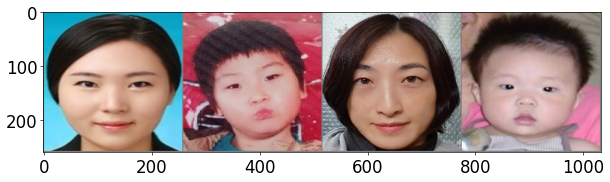

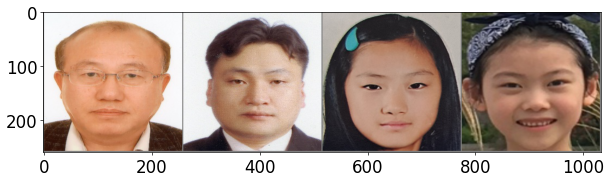

tensor([1, 0, 1, 0])


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
img1, img2, label = next(iterator)
out = torchvision.utils.make_grid(img1[:4])
imshow(out)
out = torchvision.utils.make_grid(img2[:4])
imshow(out)
print(label[:4]) # 1: family, 0: not family

#### <b>Define Models</b>

In [7]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = InceptionResnetV1(pretrained='vggface2')
        self.emb_dim = 512

        self.last = nn.Sequential(
            nn.Linear(4 * self.emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, input1, input2):
        emb1 = self.encoder(input1)
        emb2 = self.encoder(input2)
        
        x1 = torch.pow(emb1, 2) - torch.pow(emb2, 2)
        x2 = torch.pow(emb1 - emb2, 2)
        x3 = emb1 * emb2
        x4 = emb1 + emb2
        
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.last(x)

        return x

#### <b>Train a Model</b>

In [8]:
import time

lr = 0.001
log_step = 20

net = SiameseNet().cuda()
net = torch.nn.DataParallel(net)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, patience=10)
sigmoid = nn.Sigmoid()

In [9]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    net.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        img1, img2, label = batch
        img1, img2, label = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda()
        output = net(img1, img2)
        preds = sigmoid(output) >= 0.5
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, running_corrects / total


def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    net.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):

        img1, img2, label = batch
        img1, img2, label = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda()
        with torch.no_grad():
            output = net(img1, img2)
            preds = sigmoid(output) >= 0.5
            loss = criterion(output, label)

        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, running_corrects / total

In [ ]:
num_epochs = 10
best_val_loss = 1e9
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        print("[Info] best validation accuracy!")
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(net.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(net.state_dict(), f'last_checkpoint_epoch_{num_epochs}.pth')

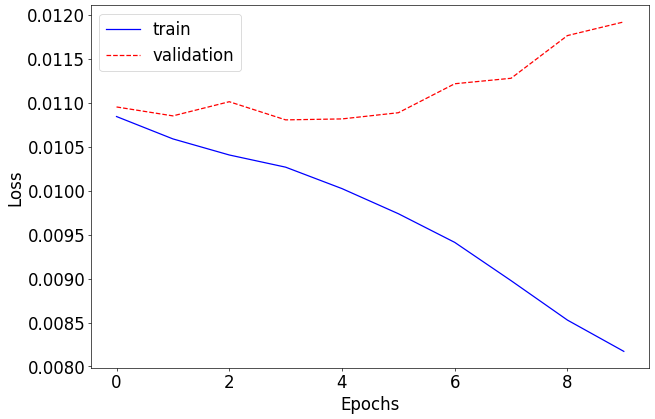

In [11]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()